<a href="https://colab.research.google.com/github/agprasanna/Coursera_Capstone/blob/master/Opening_an_Indian_Restaurant_in_Toronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install the necesary packages (if not done already)


In [19]:
#!conda install -c conda-forge geopy --yes 
#!conda install -c conda-forge folium=0.10.0 
#!conda install -c conda-forge geopandas
#!pip install geopandas

Import the necesary libraries here


In [15]:
import pandas as pd
#pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

from collections import Counter # count occurrences

import urllib.request
import requests

from geopy.geocoders import Nominatim    # import geocoder Nominatim
import folium                            # import map rendering 

import geopandas as gpd             #to read in shape file and provides high #level interface with #matplotlib library for making maps

import matplotlib.pyplot as plt
import matplotlib.cm as cm          # Matplotlib and associated plotting modules
import matplotlib.colors as colors 

#import k-means from clustering stage
from sklearn.cluster import KMeans

print("libraries imported!")

libraries imported!


Importing the geojson file from the OpenData project of City of  Toronto

In [16]:
Toronto_geojson_url= "https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15?format=geojson&projection=4326"

Toronto_Geojson = gpd.read_file(Toronto_geojson_url)
Toronto_Geojson.head(2)

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry
0,6581,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),None,None,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"POLYGON ((-79.43592 43.68015, -79.43492 43.680..."
1,6582,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),None,None,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"POLYGON ((-79.41096 43.70408, -79.40962 43.704..."


Extracting only the relevant information from the above dataset

In [17]:
Toronto_Geojson1 = Toronto_Geojson[['AREA_SHORT_CODE','geometry']]
#Toronto_Geojson1.head()

Another way to get the neighborhood names and geocoding


In [18]:
url = "https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto#Table"
table_list = pd.read_html(url)
#print("number of tables in web page = ", len(table_list))
Raw_df = table_list[11] # what we want is the 11th table in the list

#Raw_df.head()
Raw_df.drop(columns=['Map', 'Unnamed: 5'], axis=1, inplace = True)
Neighbor_df = Raw_df.rename(columns={'CDN number': 'Code', 
                                     'City-designated neighbourhood':'Neighborhood_Name', 
                                     'Former city/borough':'Borough',
                                     'Neighbourhoods covered':'Areas_Covered'
                                    })

# Explode/Split Neighbourhood column into multiple rows (removing the hyphen symbol)
new_df = pd.DataFrame(Neighbor_df.Neighborhood_Name.str.split('-').tolist(), index=Neighbor_df.Code).stack()
new_df = new_df.reset_index([0, 'Code'])
new_df['Lat'] = np.NaN
new_df['Long'] = np.NaN
new_df.columns = ['Code', 'Neighborhood_Name', 'Lat', 'Long']

#### Geo coding the longitude and lattitude values using Nominatim ###

from functools import partial
#from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent="Neighborhood_explorer")

_geocode = partial(geolocator.geocode, language="en")
geocode = lambda query, **kw: _geocode("%s, Toronto Ontario Canada" % query, **kw)
#geocode = RateLimiter(geocode_, min_delay_seconds=1)

def eval_lat(x):
    try:
        return (x.latitude)
    except:
        return (None)
def eval_lon(x):
    try:
        return (x.longitude)
    except:
        return (None)

    
new_df['Lat'] = new_df['Neighborhood_Name'].apply(geocode).apply(lambda x: eval_lat(x))
new_df['Long'] = new_df['Neighborhood_Name'].apply(geocode).apply(lambda x: eval_lon(x))

print("Geo Coding complete!")
new_df



GeocoderServiceError: ignored

In [21]:
#save the Geocded Datafrem to a CSV for future usage.
#new_df.to_csv('TorontoNeighborhoodGeocoding.csv', index = False)
#Import the geocode data from csv file 
new_df = pd.read_csv("TorontoNeighborhoodGeocoding.csv")

In [22]:
# find the neighborhoods that dont have lat,long values and drop them.
# Then remove the duplicates (keeping the first record)from "Code"
new_df[new_df.isna().any(axis=1)]
new_df.dropna(axis=0, inplace=True)
print("shape before removing duplicates: ",new_df.shape)
new_df.drop_duplicates(subset ="Code", keep = 'first', inplace = True) 
print("shape after removing duplicates: ",new_df.shape)

shape before removing duplicates:  (195, 4)
shape after removing duplicates:  (136, 4)


In [23]:
##Determining the centre for the map (I have tried two ways as mentioned below)

# Assigning centroids to map using the center point of the geojson data
#latitude= Toronto_Geojson.centroid.x.mean()
#longitude=Toronto_Geojson.centroid.y.mean()

# Assigning a selected location in Toronto as the center point, using geocoding
address = 'Glenview senior public school, Ontario, Canada'
geolocator = Nominatim(user_agent="Toronto_map")
MapCenterLocation = geolocator.geocode(address)
MapCenterLatitude = MapCenterLocation.latitude
MmapCenterLongitude = MapCenterLocation.longitude
#print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

In [24]:
Toronto_df = Toronto_Geojson[['AREA_SHORT_CODE','AREA_NAME','LONGITUDE','LATITUDE']]
#rename columns for convenience 
Toronto_df = Toronto_df.rename(columns={'AREA_SHORT_CODE': 'Code', 'AREA_NAME': 'Neighborhood', 'LONGITUDE': 'Longitude', 'LATITUDE': 'Latitude'})
Toronto_df['Neighborhood'] = Toronto_df['Neighborhood'].str.partition('(')
Toronto_df.head()

,Code,Neighborhood,Longitude,Latitude
0,94,Wychwood,-79.425515,43.676919
1,100,Yonge-Eglinton,-79.403590,43.704689
2,97,Yonge-St.Clair,-79.397871,43.687859
3,27,York University Heights,-79.488883,43.765736
4,31,Yorkdale-Glen Park,-79.457108,43.714672


In [25]:
Toronto_df.dtypes


Code              int64
Neighborhood     object
Longitude       float64
Latitude        float64
dtype: object

## Selecting the neighborhood center point 
<p> As seen from the below map, there is a significant variation of the results (for selecting the center point for a neighborhood) when using the Nominatiam geocoding method and using the centerpoid of the GeoJson data. 

Nominatiam did not return all the geocodes for all neighborhoods. Further, it does not provide an even spread between the point in some cases. i.e. two points of two neighborhoods can be very close to each other resulting in poor venue data later on.

Considering the above shortcomings, I will use the centeroid of each neighborhood geometry ploygon, as the location (lat,long) for vanue data collection.



In [26]:
# create map of Toronto using latitude and longitude values created above
map_Toronto = folium.Map(location=[MapCenterLatitude, MmapCenterLongitude], 
                         zoom_start=11,
                         width='80%',
                         height='80%', 
                         min_zoom=10,
                         max_bounds= True, 
                         min_lat=43.5,
                         max_lat=44,
                         min_lon=-79.8,
                         max_lon=-78.9)

## add markers to map using Toronto_df 
for lat, lng, neighborhood in zip(Toronto_df['Latitude'], Toronto_df['Longitude'], Toronto_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)

## add markers to map using new_df
for lat, lng, neighborhood in zip(new_df['Lat'], new_df['Long'], new_df['Neighborhood_Name']):
    label = '{}, {}, {}'.format(neighborhood,lat,lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        #fill_color='#3568cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)

## add neighborhood boundaries to map using TorontoGeojson data
folium.GeoJson(Toronto_Geojson, 
               name='Neighborhoods',
               ).add_to(map_Toronto)

folium.LayerControl().add_to(map_Toronto)



map_Toronto

## Foursquare data check 

#### Defining Foursquare Credentials 

In [27]:
## Defining Foursquare Credentials 
CLIENT_ID = 'HH15X12VLCIU2RJJ0233AP50Y4ZZ2ED1FNG5AHVAAK1FNUXB' # your Foursquare ID
CLIENT_SECRET = '0U2TM5EKCMVP1S11YS0XJBHNW5H2BMKMFDSVAVYAY0FQMHSD' # your Foursquare Secret
VERSION = '20200630' # Foursquare API version


In [28]:
#Sample URL to explore the venues around a given coordinate
#https://api.foursquare.com/v2/venues/explore?client_id=CLIENT_ID&client_secret=CLIENT_SECRET&ll=LATITUDE,LONGITUDE&v=VERSION&limit=LIMIT

## list of venune categories returned by FourSquare
#venuecategories = requests.get('https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)).json()
#venuecategories["response"]['categories'][3] #these are the parent food category


# Define the radius and limit of reponse from foursquare 
RADIUS = 1000
LIMIT = 200
CATEGORYID = '4d4b7105d754a06374d81259' #pass as 'categoryId' 

#parent food category - 4d4b7105d754a06374d81259 
#Sri Lankan Restaurant - 5413605de4b0ae91d18581a9 (covers only Sri Lankan resturants)
#Indian Restaurants - 4bf58dd8d48988d10f941735 (this category covers multiple indian cusines)
#Asian Restaurants - 4bf58dd8d48988d142941735 (this category covers chineese,Japaneese and south east asian cusines)

#For Temporary checking lat,lng set to toronto city
tmplat = 43.706740 
tmplng = -79.398328

In [29]:
# create the API request URL
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    tmplat, 
    tmplng, 
    CATEGORYID,
    RADIUS, 
    1)

# make the GET request
results = requests.get(url).json()
#results['response']['venues'] # if using venue search
results

{'meta': {'code': 200, 'requestId': '5f27766caf4413115c5edf58'},
 'response': {'confident': False,
  'venues': [{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
       'suffix': '.png'},
      'id': '4bf58dd8d48988d1e0931735',
      'name': 'Coffee Shop',
      'pluralName': 'Coffee Shops',
      'primary': True,
      'shortName': 'Coffee Shop'}],
    'hasPerk': False,
    'id': '4aec6bbaf964a520e6c621e3',
    'location': {'address': '2630 Yonge St',
     'cc': 'CA',
     'city': 'Toronto',
     'country': 'Canada',
     'crossStreet': 'at Craighurst Ave',
     'distance': 999,
     'formattedAddress': ['2630 Yonge St (at Craighurst Ave)',
      'Toronto ON M4P 2J5',
      'Canada'],
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.71559,
       'lng': -79.40045}],
     'lat': 43.71559,
     'lng': -79.40045,
     'postalCode': 'M4P 2J5',
     'state': 'ON'},
    'name': 'Starbucks',
    'referralId': 'v-1596422008'}]}}

### Define a function to retrive the near by Food venues around the centeroid of each neighborhood.

In [30]:
def getNearbyFoodVenues(names, latitudes, longitudes, radius=100, limit=10):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
      print(' .', end='')
      # create the API request URL
      url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
          CLIENT_ID, 
          CLIENT_SECRET, 
          VERSION, 
          lat, 
          lng, 
          radius,
          CATEGORYID, ## passing parent "Food" category id
          limit)
      
      try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
      except:
          not_found += 1


    nearby_food_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_food_venues.columns = ['Neighborhood',
                                  'Neighborhood Latitude', 
                                  'Neighborhood Longitude', 
                                  'Venue',
                                  'Venue Latitude',
                                  'Venue Longitude',
                                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_food_venues)
    



Using pickle library to serialize the information retrieved using the GET requests. This helps to avoid any redundant requests to the Foursquare API.


In [31]:
import pickle # This is to serialize and deserialize a Python object structure

try:
    with open('Toronto_food_venues.pkl', 'rb') as f:
        Toronto_food_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
  Toronto_food_venues = getNearbyFoodVenues(names=Toronto_df['Neighborhood'],
                                            latitudes=Toronto_df['Latitude'],
                                            longitudes=Toronto_df['Longitude'],
                                            radius=RADIUS, 
                                            limit=LIMIT)
  
  with open('Toronto_food_venues.pkl', 'wb') as f:
    pickle.dump(Toronto_food_venues, f)
  print("---Dataframe Created and Serialized---")



***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.
---Dataframe Created and Serialized---


In [32]:
#save the Food venues as a CSV for future usage.
Toronto_food_venues.to_csv('TorontoFoodVenues.csv', index = False)

In [87]:
#Import the Food venues data from csv file 
Toronto_food_venues = pd.read_csv("TorontoFoodVenues.csv")

## Preliminary Ananysis 

In [88]:
Toronto_food_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wychwood,43.676919,-79.425515,Annabelle Pasta Bar,43.675445,-79.423341,Italian Restaurant
1,Wychwood,43.676919,-79.425515,Loblaws,43.684188,-79.415485,Grocery Store
2,Wychwood,43.676919,-79.425515,Booyah,43.681744,-79.418011,Ice Cream Shop
3,Wychwood,43.676919,-79.425515,Loblaws,43.671657,-79.421364,Grocery Store
4,Wychwood,43.676919,-79.425515,Knockout Ice Cream,43.670717,-79.434551,Ice Cream Shop


In [89]:
print('A total of {} venues returned by FourSquare API'.format(Toronto_food_venues.shape[0]))
print('There are {} unique categories.\n'.format(len(Toronto_food_venues['Venue Category'].unique())))

Toronto_food_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

A total of 5815 venues returned by FourSquare API
There are 165 unique categories.



Venue Category
Coffee Shop                        658
Pizza Place                        385
Café                               334
Bakery                             283
Fast Food Restaurant               252
Restaurant                         245
Chinese Restaurant                 208
Sandwich Place                     180
Caribbean Restaurant               178
Italian Restaurant                 172
Indian Restaurant                  150
Ice Cream Shop                     132
Sushi Restaurant                    98
Asian Restaurant                    98
Grocery Store                       95
Vietnamese Restaurant               89
Japanese Restaurant                 87
Breakfast Spot                      86
Burger Joint                        83
Middle Eastern Restaurant           82
Thai Restaurant                     73
American Restaurant                 73
Dessert Shop                        72
Mexican Restaurant                  72
BBQ Joint                           72
Diner     

We are only interested in the distribution of different food cuisines amoung the neighborhoods. Therefore I will manually create a list of generic venue categories returend by FourSquare, and remove them from the dataframe.


I analyzed the type and number of venues returned from each category and removed below categories from our dataset.


* Coffee shops/ cafe/ cafeteria 
* Sweets/ desert shops and bakeries
* Pubs/ bars or similar categories  
* snack and hot-dog categories  
* any other non-restaurent category with less than 10 venue results 

In [90]:
# list all the categories returned by Foursquare
unique_categories = Toronto_food_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Italian Restaurant, Grocery Store, Ice Cream Shop, Breakfast Spot, Coffee Shop, Café, Jewish Restaurant, Indian Restaurant, Noodle House, Shawarma Place, Chinese Restaurant, Bagel Shop, Dessert Shop, Bakery, Empanada Restaurant, Filipino Restaurant, Sushi Restaurant, Vietnamese Restaurant, Bistro, Caribbean Restaurant, Peruvian Restaurant, Mediterranean Restaurant, Fish & Chips Shop, Mexican Restaurant, Fast Food Restaurant, Deli / Bodega, Burger Joint, Syrian Restaurant, Snack Place, Pizza Place, Bubble Tea Shop, Restaurant, Seafood Restaurant, Indonesian Restaurant, Supermarket, Wine Bar, Buffet, Thai Restaurant, Wings Joint, Diner, Ramen Restaurant, Bar, Taco Place, Sandwich Place, American Restaurant, Food Service, Poke Place, Juice Bar, Asian Restaurant, French Restaurant, Pastry Shop, Modern European Restaurant, Middle Eastern Restaurant, Japanese Restaurant, Gastropub, Salad Place, Lounge, Greek Restaurant, Halal Restaurant, Falafel Restaurant, Pool Hall, Fried Chicken Joint, Bo

In [91]:
## Select the generic / unwanted categories and make a list.
generic_categories = ['Grocery Store','Coffee Shop','Ice Cream Shop','Fish & Chips Shop','Breakfast Spot','Café','Deli / Bodega','Noodle House','Bakery',
                      'Dessert Shop','Bagel Shop','Shawarma Place','Bistro','Burger Joint','Bubble Tea Shop','Snack Place','Pizza Place','Taco Place','Supermarket',
                      'Bar','Wine Bar','Buffet','Wings Joint','Diner','Sandwich Place','Juice Bar','Food Service','Pastry Shop','Poke Place','Gastropub','Salad Place',
                      'Lounge','Pool Hall','Fried Chicken Joint','Bowling Alley','Steakhouse','Hot Dog Joint','Candy Store','BBQ Joint','Cupcake Shop','Frozen Yogurt Shop',
                      'Pub','Butcher','Food & Drink Shop','Food Court','Sports Bar','Bike Shop','Beer Bar','Hotel, Event Space','Whisky Bar','Convenience Store',
                      'Burrito Place','Tea Room','Irish Pub','Food','Donut Shop','Cafeteria','Poutine Place','Gourmet Shop','Office','Food Truck','Sake Bar',
                      'Harbor / Marina','Gas Station','Brewery','Cocktail Bar','Fish Market','Coworking Space','Beach','Food Stand','Factory','Hookah Bar','Speakeasy',
                      'Bookstore','Karaoke Bar','Mac & Cheese Joint','Comic Shop','Hardware Store','Chaat Place','Souvlaki Shop','Restaurant'
                      ]



#['Coffee Shop','Pizza Place','Café','Bakery','Ice Cream Shop','Grocery Store','Dessert Shop','Bubble Tea Shop','Deli / Bodega',
                      #'Gastropub','Juice Bar','Food Truck','Bagel Shop','Snack Place','Bar,Tea Room','Hot Dog Joint','Donut Shop','Pub','Frozen Yogurt Shop',
                      #'Poke Place','Bistro','Butcher','Food','Supermarket','Taco Place','Brewery','Beer Bar','Convenience Store','Salad Place','Shawarma Place',
                      #'Gourmet Shop','Wine Bar','Cupcake Shop','Theme Restaurant','Cafeteria','Pastry Shop','Sports Bar','Buffet,Whisky Bar','Irish Pub',
                      #'Gas Station','Office','Food Stand','Poutine Place','Bike Shop','Hookah Bar','Food Service','Speakeasy','Fish Market','Harbor / Marina',
                      #'Event Space','Cocktail Bar','Hotel','Mac & Cheese Joint','Coworking Space','Beach','Food & Drink Shop','Bookstore','Karaoke Bar',
                      #'Lounge','Bowling Alley','Chaat Place','Souvlaki Shop','Comic Shop','Sake Bar','Pool Hall','Candy Store','Factory','Hardware Store',
                      #'Fast Food Restaurant','Restaurant','Burger Joint','Sandwich Place',
                      #'BBQ Joint', 'Fried Chicken Joint','Whisky Bar', 'Bar', 'Diner', 
                      #'Food Court', 'Breakfast Spot','Wings Joint','Tea Room','Buffet'

                      #]


In [92]:
# fetch all the required food categories
food_categories =  list(set(unique_categories) - set(generic_categories))
print(', '.join(str(x) for x in food_categories))

Jewish Restaurant, Scandinavian Restaurant, Portuguese Restaurant, American Restaurant, Italian Restaurant, Cajun / Creole Restaurant, Middle Eastern Restaurant, Halal Restaurant, Afghan Restaurant, French Restaurant, Spanish Restaurant, Thai Restaurant, Event Space, Malay Restaurant, Hakka Restaurant, Modern European Restaurant, Burmese Restaurant, Argentinian Restaurant, Japanese Restaurant, Eastern European Restaurant, Ukrainian Restaurant, Vietnamese Restaurant, Hungarian Restaurant, Kosher Restaurant, North Indian Restaurant, Syrian Restaurant, Polish Restaurant, Hawaiian Restaurant, Peruvian Restaurant, Doner Restaurant, Falafel Restaurant, Colombian Restaurant, Asian Restaurant, Egyptian Restaurant, Belgian Restaurant, Israeli Restaurant, Latin American Restaurant, Fast Food Restaurant, Tibetan Restaurant, Vegetarian / Vegan Restaurant, Sri Lankan Restaurant, Ramen Restaurant, South Indian Restaurant, Mexican Restaurant, Indonesian Restaurant, Filipino Restaurant, Seafood Restau

In [93]:

## Removing the generic categories from the data frame.
Toronto_food_venues = Toronto_food_venues[Toronto_food_venues['Venue Category'].isin(food_categories)].reset_index()


In [94]:
print('There are {} unique "Food categories".'.format(len(Toronto_food_venues['Venue Category'].unique())))
print('There are {} uniques "Venues".'.format(len(Toronto_food_venues['Venue'].unique())))

There are 85 unique "Food categories".
There are 1576 uniques "Venues".


## Analyze each neighborhood 

Use onehot encoding 

In [95]:
Toronto_onehot = pd.get_dummies(Toronto_food_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column to the dataframe
Toronto_onehot.insert(0, 'Neighborhood', Toronto_food_venues['Neighborhood'])

Toronto_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Bangladeshi Restaurant,Belgian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Hawaiian Restaurant,Hong Kong Restaurant,Hotel,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,...,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Satay Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant
0,Wychwood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wychwood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wychwood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wychwood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wychwood,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [96]:
#inspect the sum of each venue category in each neighborhood
venue_counts = Toronto_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Bangladeshi Restaurant,Belgian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Hawaiian Restaurant,Hong Kong Restaurant,Hotel,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,...,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Satay Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Agincourt North,0,0,0,0,0,0,0,0,0,0,0,2,7,0,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,3,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
Agincourt South-Malvern West,0,0,1,0,4,0,0,0,0,0,3,3,11,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
Alderwood,0,0,0,0,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,1,0,1,0,0
Annex,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,...,3,0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
Banbury-Don Mills,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [97]:
Toronto_venues_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
print("shape of Toronto_venues_grouped is",Toronto_venues_grouped.shape)

shape of Toronto_venues_grouped is (139, 86)


It seems that we have lost 20 neighborhoods from the original 140 

### Write a function to return the most common venues

In [98]:
def get_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
    

In [99]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_venues_grouped['Neighborhood']

for ind in np.arange(Toronto_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = get_most_common_venues(Toronto_venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt North,Chinese Restaurant,Indian Restaurant,Fast Food Restaurant,Caribbean Restaurant,Sushi Restaurant
1,Agincourt South-Malvern West,Chinese Restaurant,Asian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Hong Kong Restaurant
2,Alderwood,Asian Restaurant,Thai Restaurant,Indian Restaurant,Italian Restaurant,New American Restaurant
3,Annex,Korean Restaurant,Italian Restaurant,Fast Food Restaurant,Japanese Restaurant,Sushi Restaurant
4,Banbury-Don Mills,Japanese Restaurant,Sushi Restaurant,New American Restaurant,Indian Restaurant,Middle Eastern Restaurant


In [100]:
neighborhoods_venues_sorted.shape

(139, 6)

## Clustering the Neighborhoods




First we need to find the optimum number for 'k' in k-means clustering.

I'm going try the **"Elbow Method"** first. The calculation works as follows.


Calculate the sum of squared distances of samples to their respective cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen as the optimal 'k'

In [101]:
## Create a new data frame for clustering
Toronto_venues_grouped_Clustering = Toronto_venues_grouped.drop('Neighborhood', 1)

In [102]:
from sklearn.metrics import silhouette_score

kmeans_results = []
sum_of_squared_distances = []
sil = []

K = range(2,32)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(init="k-means++", n_clusters=k, n_init=30, random_state=4).fit(Toronto_venues_grouped_Clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(Toronto_venues_grouped_Clustering, labels, metric = 'euclidean'))
    kmeans_results.append(kmeans)
    sum_of_squared_distances.append(kmeans.inertia_)


2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

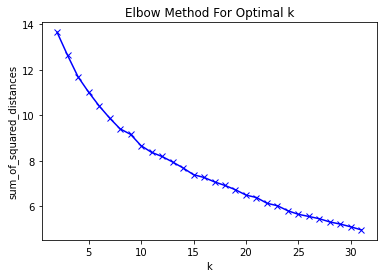

In [103]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');


Text(0.5, 1.0, 'Silhouette Method For Optimal k')

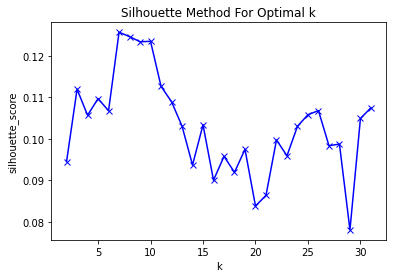

In [104]:
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')


Elbow methd doesn't seem to give a clear cut point as per the graph.Therefore I will use the silhouette_score method, hoping for better luck

Accordinng to the silhouette method results k=4 gives us the highest peak score before it deteriorates. k=2 is obvious and is not selected as the optimal k here.

In [105]:
for i in K:
  print(Counter(kmeans_results[i-2].labels_))

Counter({1: 82, 0: 57})
Counter({1: 96, 2: 37, 0: 6})
Counter({1: 67, 2: 35, 0: 31, 3: 6})
Counter({4: 62, 1: 34, 0: 19, 2: 18, 3: 6})
Counter({3: 38, 2: 31, 1: 27, 0: 21, 5: 16, 4: 6})
Counter({5: 38, 6: 30, 3: 25, 2: 20, 1: 15, 4: 6, 0: 5})
Counter({3: 41, 6: 26, 5: 21, 2: 18, 1: 17, 4: 6, 7: 5, 0: 5})
Counter({3: 35, 6: 27, 5: 21, 1: 17, 2: 17, 0: 6, 4: 6, 7: 5, 8: 5})
Counter({2: 32, 6: 24, 3: 19, 1: 16, 5: 15, 9: 15, 0: 6, 4: 5, 7: 5, 8: 2})
Counter({5: 36, 4: 24, 3: 18, 7: 17, 2: 16, 1: 6, 8: 6, 0: 5, 10: 5, 9: 5, 6: 1})
Counter({4: 27, 1: 25, 5: 25, 7: 19, 3: 16, 6: 8, 2: 6, 10: 5, 8: 4, 9: 2, 11: 1, 0: 1})
Counter({5: 41, 3: 18, 2: 16, 4: 16, 7: 15, 12: 7, 0: 5, 10: 5, 9: 5, 1: 4, 11: 4, 8: 2, 6: 1})
Counter({1: 29, 11: 18, 12: 17, 4: 16, 2: 15, 8: 12, 0: 10, 5: 6, 3: 4, 6: 4, 10: 3, 9: 3, 7: 1, 13: 1})
Counter({3: 27, 2: 22, 5: 16, 1: 13, 8: 12, 0: 12, 13: 11, 11: 6, 4: 6, 7: 4, 9: 4, 10: 2, 14: 2, 6: 1, 12: 1})
Counter({3: 27, 2: 19, 5: 15, 1: 14, 8: 12, 13: 11, 15: 9, 11: 6,

**K = 4 is the most appropriate value**

In [138]:
Best_K_Value = 7

## Clustering using k-Means

Now let's add the cluster label to the original data frame. <p>
Run the blow cell twice if you want to change the assigned K value.

In [125]:
# add clustering labels
#Toronto_Clstered = neighborhoods_venues_sorted
try:
  neighborhoods_venues_sorted.insert(1, 'Cluster Labels', kmeans_results[Best_K_Value-2].labels_)   
except:
  neighborhoods_venues_sorted.drop('Cluster Labels', axis=1,inplace=True)
  neighborhoods_venues_sorted.insert(1, 'Cluster Labels', kmeans_results[Best_K_Value-2].labels_)


In [126]:
neighborhoods_venues_sorted.shape

(139, 7)

In [127]:
Toronto_clustered = neighborhoods_venues_sorted.join(Toronto_df.set_index('Neighborhood'), on='Neighborhood')
Toronto_clustered.shape

(139, 10)

In [128]:
Toronto_clustered.head()

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Code,Longitude,Latitude
0,Agincourt North,1,Chinese Restaurant,Indian Restaurant,Fast Food Restaurant,Caribbean Restaurant,Sushi Restaurant,129,-79.266712,43.805441
1,Agincourt South-Malvern West,1,Chinese Restaurant,Asian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Hong Kong Restaurant,128,-79.265612,43.788658
2,Alderwood,3,Asian Restaurant,Thai Restaurant,Indian Restaurant,Italian Restaurant,New American Restaurant,20,-79.541611,43.604937
3,Annex,5,Korean Restaurant,Italian Restaurant,Fast Food Restaurant,Japanese Restaurant,Sushi Restaurant,95,-79.404001,43.671585
4,Banbury-Don Mills,3,Japanese Restaurant,Sushi Restaurant,New American Restaurant,Indian Restaurant,Middle Eastern Restaurant,42,-79.349718,43.737657


In [168]:
ClusterResults=[]

for clusterNumber in range(Best_K_Value):
  ClusterResults.append(Toronto_clustered.loc[Toronto_clustered['Cluster Labels'] == clusterNumber, Toronto_clustered.columns[1:6]])
  #ClusterResults[clusterNumber] = ClusterX




In [181]:
ClusterResults[0] # Greek
ClusterResults[1] # Chinese
ClusterResults[2] # Caribbean
ClusterResults[3] # Japaneese / South East asian / Indian / Mostly a mix bag
ClusterResults[4] # Korean
ClusterResults[5] # Italian
ClusterResults[6] # Fast Food

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
6,6,Fast Food Restaurant,Italian Restaurant,Japanese Restaurant,Thai Restaurant
19,6,Fast Food Restaurant,Sushi Restaurant,Japanese Restaurant,Thai Restaurant
23,6,Fast Food Restaurant,Italian Restaurant,American Restaurant,Theme Restaurant
25,6,Filipino Restaurant,Fast Food Restaurant,Asian Restaurant,Italian Restaurant
30,6,Fast Food Restaurant,Chinese Restaurant,Asian Restaurant,Caribbean Restaurant
33,6,Vietnamese Restaurant,Turkish Restaurant,Fast Food Restaurant,Latin American Restaurant
36,6,Japanese Restaurant,Indian Restaurant,Fast Food Restaurant,Greek Restaurant
37,6,Fast Food Restaurant,Caribbean Restaurant,Sri Lankan Restaurant,Filipino Restaurant
48,6,Fast Food Restaurant,Sushi Restaurant,Mediterranean Restaurant,Asian Restaurant
49,6,Indian Restaurant,Fast Food Restaurant,Mexican Restaurant,Ramen Restaurant


In [172]:
# create map
map_clusters = folium.Map(location=[MapCenterLatitude, MmapCenterLongitude], 
                         zoom_start=11,
                         width='80%',
                         height='80%', 
                         min_zoom=10,
                         max_bounds= True, 
                         min_lat=43.5,
                         max_lat=44,
                         min_lon=-79.8,
                         max_lon=-78.9)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, Best_K_Value))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_clustered['Latitude'], Toronto_clustered['Longitude'], Toronto_clustered['Neighborhood'], Toronto_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters